In [526]:
import numpy as np
from scipy.stats import nbinom, poisson
import matplotlib.pyplot as plt
import pandas as pd
import pyswarms as ps

## Shared parameters log-bell
def link(t, mu, k1, k2, t0):
    """

    :param t: pseudotime
    :param mu: peak expression value
    :param k1: activation strength or how quickly a gene is up regulated (increasing)
    :param k2: activation strength or how quickly a gene is down regulated (decreasing)
    :param t0: turning point
    :return:
    """
    part1 = mu * np.exp(- np.abs(k1) * (t - t0) ** 2) * (np.sign(k1) + (k1 == 0))
    part2 = mu * np.exp(- np.abs(k2) * (t - t0) ** 2) * (np.sign(k2) + (k2 == 0))

    return part1 * (t <= t0) + part2 * (t > t0)

## Zero-inflated Poisson
def single_gene_log_likelihood_ZIP(y, t, mu, k1, k2, t0, alpha, beta):
    """

    :param y:
    :param t:
    :param mu:
    :param k1:
    :param k2:
    :param t0:
    :param p:
    :return:
    """
    bell = link(t, mu, k1, k2, t0)
    mut = np.maximum(np.exp(bell), 0.1)
    cache = poisson.pmf(y, mut) + 1e-300

    ## Zero-inflation
    p = 1 / (1 + np.exp(alpha * np.log(mut) + beta))

    return - np.log(cache * (1 - p) + p * (y == 0)).sum()

def make_cuckoo_zip_obj(y, t):
    def obj(b):
        mu, k1, k2, t0,  alpha, beta = b
        # return single_gene_log_likelihood_ZIP(y, t, mu, k1, k2, t0, alpha, beta)
        return single_gene_log_likelihood_Poisson(y, t, mu, k1, k2, t0)

        # Bounds based on y and t
    bounds = [
        np.log(np.min(y + 1)),   # log(mu) lower bound
        -np.inf,                 # k1
        -np.inf,                 # k2
        t.min(),                 # t0
        # -np.inf,                 # phi
        -np.inf,                 # alpha
        -np.inf                  # beta
    ], [
        np.log(np.max(y)),       # log(mu) upper bound
        np.inf,                  # k1
        np.inf,                  # k2
        t.max(),                 # t0
        # np.inf,                  # phi
        np.inf,                  # alpha
        np.inf                   # beta
    ]
    
    # Convert to list of tuples for optimizers like `scipy.optimize.minimize`
    bounds = list(zip(*bounds))

    return obj, bounds

## Plot the results
def plot_result(para_pso, para_cso, t, y1, gene_name=None):
    mu_fit, k1_fit, k2_fit, t0_fit = np.abs(para_cs[:4])
    log_mut_fit = link(np.sort(t), mu_fit, k1_fit, k2_fit, t0_fit)
    p_fit = 0 # 1 / (1 + np.exp(para[-1] + para[-2] * np.exp(log_mut_fit)))
    ZIlog_mut_fit = np.maximum(log_mut_fit + np.log(1 - p_fit), 0)

    plt.plot(np.sort(t), log_mut_fit, linewidth=3, c="red", label="CS fitted curve")

    mu_fit, k1_fit, k2_fit, t0_fit = np.abs(para_pso[:4])
    log_mut_fit = link(np.sort(t), mu_fit, k1_fit, k2_fit, t0_fit)
    p_fit = 0 # 1 / (1 + np.exp(para[-1] + para[-2] * np.exp(log_mut_fit)))
    ZIlog_mut_fit = np.maximum(log_mut_fit + np.log(1 - p_fit), 0)

    plt.plot(np.sort(t), log_mut_fit, linewidth=3, c="blue", label="PSO fitted curve")

    plt.xlabel("Pseudotime", fontsize=13)
    plt.ylabel("Expression log(count+1)", fontsize=13)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.scatter(t, np.log(y1 + 1), c="grey", alpha=0.7, s=7)
    plt.title(gene_name,  fontsize=16)
    plt.legend(loc='upper right')


In [251]:
data = pd.read_csv("wang_sce_selected.csv").sort_values(by="pseudotime")
data.head()

,Index,pseudotime,PLAU,MMP7,THBS1,CADM1,NPAS3,ATP1A1,ANK3,ALPL,...,MT1F,MT1X,MT1E,MT1G,CXCL14,MAOA,DPP4,NUPR1,GPX3,PAEP
110,1772162156_C86_G5,0.000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
900,1782163185_C52_A10,0.010669,0,1289,1,0,0,0,0,0,...,0,0,0,0,5,0,0,0,0,0
883,1782163177_C03_A1,0.010807,2,157,14,6,8,152,0,0,...,0,0,0,1,0,0,0,1,0,6
879,1782163177_C18_C7,0.011814,5,2,227,7,0,0,161,0,...,0,0,0,0,0,0,0,0,0,95
579,1782147113_C14_C2,0.013716,0,3267,41,1,0,0,0,0,...,119,0,0,0,0,0,0,0,0,3046


In [494]:
# t = data.iloc[:, 1]
# for idx in range(2, 16):
#     y = data.iloc[:, idx]
#     gene_name = data.columns[idx]
    
#     # Create the objective function
#     obj_func, bounds = make_cuckoo_zip_obj(y, t)
    
    
#     _, para_pso = pso_estimation(y, t, "ZIP", 250)
    
#     lb = np.array([np.log(np.min(y + 1)), -10, -10, t.min(), -10, -10])
#     ub = np.array([np.log(np.max(y)), 10, 10, t.max(), 10, 10])
#     nd = len(lb)
    
#     para_cs, best_value = cuckoo_search_custom(
#         fitness_func=obj_func, nd=nd, lb=lb, ub=ub, n=35,
#         N_IterTotal=300
#     )
#     print(gene_name)
    
#     print("PSO value:", _)
#     print("CS value:", best_value)
    
#     plot_result(para_pso, para_cs, t, y, gene_name)
#     plt.show()

ERROR! Session/line number was not unique in

In [646]:
t = data.iloc[:, 1]
idx = 15
y = data.iloc[:, idx]
gene_name = data.columns[idx]

# Create the objective function
obj_func, bounds = make_cuckoo_zip_obj(y, t)

In [648]:
_, para_pso = pso_estimation(y, t, "Poisson", 200)

2025-04-03 23:05:47,926 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 1.2, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████|200/200, best_cost=1.14e+5
2025-04-03 23:05:51,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 113624.11877987951, best pos: [ 6.03164153  7.28589183 11.52661857  0.66705669  2.04840559 -0.12394927]


In [649]:
lb = np.array([np.log(np.min(y + 1)), -10, -10, t.min(), -10, -10])
ub = np.array([np.log(np.max(y)), 10, 10, t.max(), 10, 10])
nd = len(lb)

para_cs, best_value = cuckoo_search_custom(
    fitness_func=obj_func, nd=nd, lb=lb, ub=ub, n=35,
    N_IterTotal=300
)

print("Best parameters found:", para_cs)
print("Best objective value:", best_value)

Best parameters found: [ 6.05377588  2.6903052  -6.52748356  0.80169604  3.12384484  1.78075519]
Best objective value: 112981.38242072522


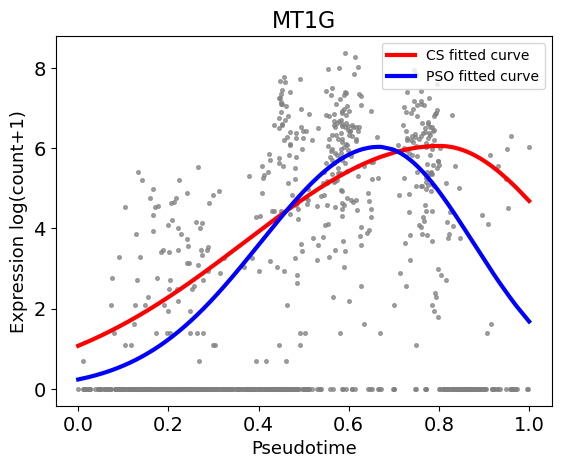

In [650]:
plot_result(para_pso, para_cs, t, y, gene_name)

In [311]:
import numpy as np
import math

# -------------------------------
# Simple bounds application
def simple_bounds(s, lb, ub):
    return np.minimum(np.maximum(s, lb), ub)

# -------------------------------
# Generate cuckoos using Levy flights
def get_cuckoos(nest, best, lb, ub):
    n, d = nest.shape
    beta = 1.5
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) /
             (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    
    for j in range(n):
        s = nest[j]
        u = np.random.randn(d) * sigma
        v = np.random.randn(d)
        step = u / (np.abs(v) ** (1 / beta))
        stepsize = 0.01 * step * (s - best)
        s = s + stepsize * np.random.randn(d)
        nest[j] = simple_bounds(s, lb, ub)
    return nest

# -------------------------------
# Replace some nests with new solutions
def empty_nests(nest, lb, ub, pa):
    n, d = nest.shape
    K = np.random.rand(n, d) > pa
    stepsize = np.random.rand() * (nest[np.random.permutation(n)] - nest[np.random.permutation(n)])
    new_nest = nest + stepsize * K
    for j in range(n):
        new_nest[j] = simple_bounds(new_nest[j], lb, ub)
    return new_nest

# -------------------------------
# Evaluate and update best nests
def get_best_nest(nest, newnest, fitness, fitness_func):
    for j in range(len(nest)):
        fnew = fitness_func(newnest[j])
        if fnew <= fitness[j]:
            fitness[j] = fnew
            nest[j] = newnest[j]
    fmin = np.min(fitness)
    best = nest[np.argmin(fitness)]
    return fmin, best, nest, fitness

# -------------------------------
# Main cuckoo search function with user-specified fitness function
def cuckoo_search_custom(fitness_func, nd, lb, ub, n=25, N_IterTotal=1000, pa=0.25):
    """
    Custom Cuckoo Search Optimizer.

    Parameters:
    - fitness_func: Callable, user-defined fitness function taking a parameter vector b
    - nd: int, number of dimensions (length of b)
    - lb: array-like, lower bounds
    - ub: array-like, upper bounds
    - n: int, number of nests (population size)
    - N_IterTotal: int, number of iterations
    - pa: float, discovery rate of alien eggs/solutions

    Returns:
    - bestnest: array, best solution found
    - fmin: float, value of fitness function at bestnest
    """
    nest = np.random.rand(n, nd) * (ub - lb) + lb
    fitness = np.full(n, 1e10)
    fmin, bestnest, nest, fitness = get_best_nest(nest, nest, fitness, fitness_func)

    for _ in range(N_IterTotal):
        new_nest = get_cuckoos(nest.copy(), bestnest, lb, ub)
        fmin, bestnest, nest, fitness = get_best_nest(nest, new_nest, fitness, fitness_func)
        new_nest = empty_nests(nest.copy(), lb, ub, pa)
        fmin, bestnest, nest, fitness = get_best_nest(nest, new_nest, fitness, fitness_func)

    return bestnest, fmin


In [377]:
def pso_estimation(y, t, marginal, iter=50):

    n = 30
    if marginal in ["Poisson", "ZIP"]:
        d = 6
        bounds = [np.array([np.log((np.min(y + 1))) , -np.inf, -np.inf, t.min(), -np.inf, -np.inf]),
                  np.array([np.log((np.max(y))) , np.inf, np.inf, t.max(), np.inf, np.inf])]
    elif marginal in ["NB", "ZINB"]:
        d = 7
        bounds = [np.array([np.log(np.min(y) + 1) , -np.inf, -np.inf, t.min(), 1, 0, 0]),
                  np.array([np.log(np.max(y) + 1) , np.inf, np.inf, t.max(), 100, 100, 100])]
    else:
        raise ValueError("Enter a valid marginal distribution: [NB, ZINB, Poisson, ZIP]!")

    np.random.seed(123)
    b = np.random.random((n, d))

    # Set-up hyperparameters and correct initial position
    options = {'c1': 1.2, 'c2': 0.3, 'w': 0.9}
    b[:, 0] = np.log(np.mean(y) + 1)
    b[:, -1] = 0.1
    b[:, 1] += 5
    b[:, 2] += 5
    #b[:, 3] = 0.9
    if d == 7:
        b[:, -3] += 1

    # Call instance of PSO
    gmodel = ps.single.GlobalBestPSO(n_particles=n, dimensions=b.shape[1], options=options, bounds=bounds, init_pos=b)

    # Perform optimization
    gcost, gbest = gmodel.optimize(pso_obj_fct, iters=iter, y=y, t=t, marginal=marginal)

    return [gcost, gbest]